<a href="https://colab.research.google.com/github/madhupriya24/zeroday_attackdetections/blob/main/CICDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/mimansari/lccde-ml-nid-2017
Corresponding Attack Types:

0 BENIGN   18225

3 DoS     3042

6 WebAttack  2180

1 Bot     1966

5 PortScan   1255

2 BruteForce   96

4 Infiltration   36

In [ ]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
final_df = pd.read_csv("/content/CICIDS2017_sample_km.csv")

In [ ]:
final_df.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PS

In [ ]:
# prompt: create another row where Label != 0 is 1 else 0
final_df['Label_New'] = final_df['Label'].apply(lambda x: 1 if x != 0 else 0)


In [ ]:
# Split dataset: Zero-day (BruteForce & Infiltration) vs. Other Attacks
zero_day_df = final_df[final_df['Label'].isin([2, 4])]
df = final_df[~final_df['Label'].isin([2, 4])]

In [ ]:
# prompt: value_counts of df of Label
print(df['Label_New'].value_counts())

Label_New
0    18225
1     8443
Name: count, dtype: int64


<ipython-input-32-f79b9527ab19>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)
<ipython-input-32-f79b9527ab19>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-32-f79b9527ab19>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

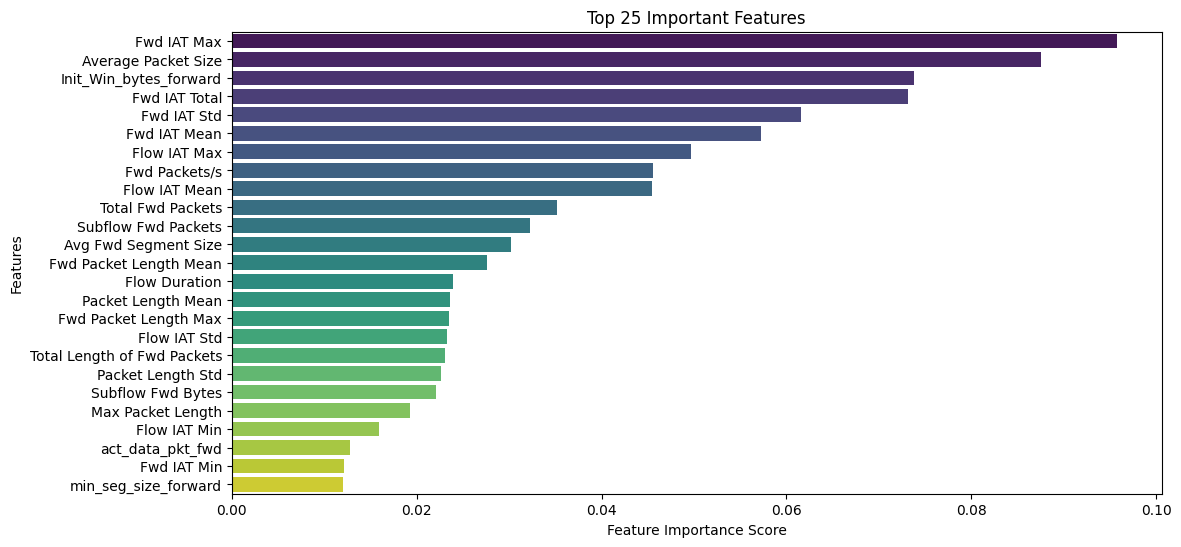

Selected Features: ['Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Mean', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd Packets/s', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Average Packet Size', 'Avg Fwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Init_Win_bytes_forward']
Label_New
0    2509
1     220
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#Step 1: Remove Duplicates
df.drop_duplicates(inplace=True)

#Step 2: Handle Missing Values
#Fill missing numerical values with median, categorical with mode
for col in df.columns:
    if df[col].dtype == 'object':  # Categorical columns
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:  # Numerical columns
        df[col].fillna(df[col].median(), inplace=True)

#Step 3: Remove Outliers using IQR
def remove_outliers(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]

#numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
df = remove_outliers(df, numerical_columns)

# Step 4: Feature Selection (Using RandomForest)
def feature_selection(df, target_column="Label_New"):
    X = df.drop(columns=[target_column,'Label'])
    y = df[target_column]

    # Train RandomForest to get feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Get feature importance
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    # Plot Top 25 Important Features
    plt.figure(figsize=(12, 6))
    sns.barplot(x=feature_importances.values[:25], y=feature_importances.index[:25], palette="viridis")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.title("Top 25 Important Features")
    plt.show()

    # Select important features
    selector = SelectFromModel(rf, threshold="mean", prefit=True)
    selected_features = X.columns[(selector.get_support())]

    print("Selected Features:", selected_features.tolist())
    return df[selected_features.tolist() + [target_column]]

df = feature_selection(df)

print(df['Label_New'].value_counts())

In [ ]:
final_df.shape

(26800, 79)

In [ ]:
df.shape

(2729, 23)

In [ ]:
X = df.drop(['Label_New'],axis=1)
y = df['Label_New']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0) #shuffle=False
#SMOTE to solve class-imbalance
pd.Series(y_train).value_counts()
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={1:14584})
X_train, y_train = smote.fit_resample(X_train, y_train)
pd.Series(y_train).value_counts()

,count
Label_New,
1,14584
0,2005


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GRU, LSTM, Bidirectional, Attention, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert labels to categorical (for deep learning models)
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Reshape input for CNN/GRU/BiLSTM models (Add a 3rd dimension for Conv1D)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9835164835164835
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       504
           1       0.82      1.00      0.90        42

    accuracy                           0.98       546
   macro avg       0.91      0.99      0.95       546
weighted avg       0.99      0.98      0.98       546



In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Evaluate XGBoost
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:13:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9871794871794872
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       504
           1       0.86      1.00      0.92        42

    accuracy                           0.99       546
   macro avg       0.93      0.99      0.96       546
weighted avg       0.99      0.99      0.99       546



In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        q, v = inputs, inputs
        attention_scores = tf.matmul(q, v, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        return tf.matmul(attention_weights, v)

cnn_bilstm_attention = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Bidirectional(LSTM(64, return_sequences=True)),
    AttentionLayer(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

cnn_bilstm_attention.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
cnn_bilstm_attention.fit(X_train_cnn, y_train_cat, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test_cat))

# Evaluate CNN-BiLSTM-Attention
cnn_bilstm_pred = cnn_bilstm_attention.predict(X_test_cnn).argmax(axis=1)
print("CNN-BiLSTM-Attention Accuracy:", accuracy_score(y_test, cnn_bilstm_pred))
print(classification_report(y_test, cnn_bilstm_pred))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


519/519 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8860 - loss: 0.3821 - val_accuracy: 0.8938 - val_loss: 0.2776
Epoch 2/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9801 - loss: 0.0892 - val_accuracy: 0.9139 - val_loss: 0.2356
Epoch 3/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.9866 - loss: 0.0578 - val_accuracy: 0.8993 - val_loss: 0.2933
Epoch 4/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.9856 - loss: 0.0600 - val_accuracy: 0.9176 - val_loss: 0.2051
Epoch 5/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9856 - loss: 0.0585 - val_accuracy: 0.8425 - val_loss: 0.4344
Epoch 6/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.9832 - loss: 0.0718 - val_accuracy: 0.9103 - val_loss: 0.3030
Epoch 7/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9897 - loss: 0.0470 - val_accuracy: 0.9158 - val_loss: 0.2007
Epoch 8/10
519/519 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.9905 - loss: 0.0442 - val_accurac

In [ ]:
selected_features = ['Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Packets/s', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'PSH Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward']
zero_day_df = zero_day_df[selected_features + ['Label_New']]

In [ ]:
X_zero = zero_day_df.drop(['Label_New'],axis=1)
y_zero = zero_day_df['Label_New']

In [ ]:
X_zero = np.array(X_zero)
y_zero = np.array(y_zero)

# Convert labels to categorical for deep learning models
y_zero_cat = to_categorical(y_zero, num_classes=num_classes)

# Reshape for CNN/GRU/BiLSTM models
X_zero_cnn = X_zero.reshape(X_zero.shape[0], X_zero.shape[1], 1)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score # Import necessary functions
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if isinstance(model, Sequential):
        y_pred = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return acc, prec, rec, f1

In [ ]:
# Evaluate Random Forest
acc_rf, prec_rf, rec_rf, f1_rf = evaluate_model(rf, X_zero, y_zero)

# Evaluate XGBoost
acc_xgb, prec_xgb, rec_xgb, f1_xgb = evaluate_model(xgb, X_zero, y_zero)

# Evaluate CNN-GRU
acc_cnn_gru, prec_cnn_gru, rec_cnn_gru, f1_cnn_gru = evaluate_model(cnn_gru, X_zero_cnn, y_zero)

# Evaluate CNN-BiLSTM-Attention
acc_cnn_bilstm, prec_cnn_bilstm, rec_cnn_bilstm, f1_cnn_bilstm = evaluate_model(cnn_bilstm_attention, X_zero_cnn, y_zero)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [ ]:
import pandas as pd

# Create DataFrame for easy comparison
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "CNN-GRU", "CNN-BiLSTM-Attention"],
    "Accuracy": [acc_rf, acc_xgb, acc_cnn_gru, acc_cnn_bilstm],
    "Precision": [prec_rf, prec_xgb, prec_cnn_gru, prec_cnn_bilstm],
    "Recall": [rec_rf, rec_xgb, rec_cnn_gru, rec_cnn_bilstm],
    "F1-Score": [f1_rf, f1_xgb, f1_cnn_gru, f1_cnn_bilstm]
})

results_df = results_df.round(2)

# Print Results
print(results_df)

                  Model  Accuracy  Precision  Recall  F1-Score
0         Random Forest      0.22       0.35    0.22      0.28
1               XGBoost      0.30       0.42    0.30      0.35
2               CNN-GRU      0.22       0.45    0.22      0.36
3  CNN-BiLSTM-Attention      0.42       0.64    0.42      0.59


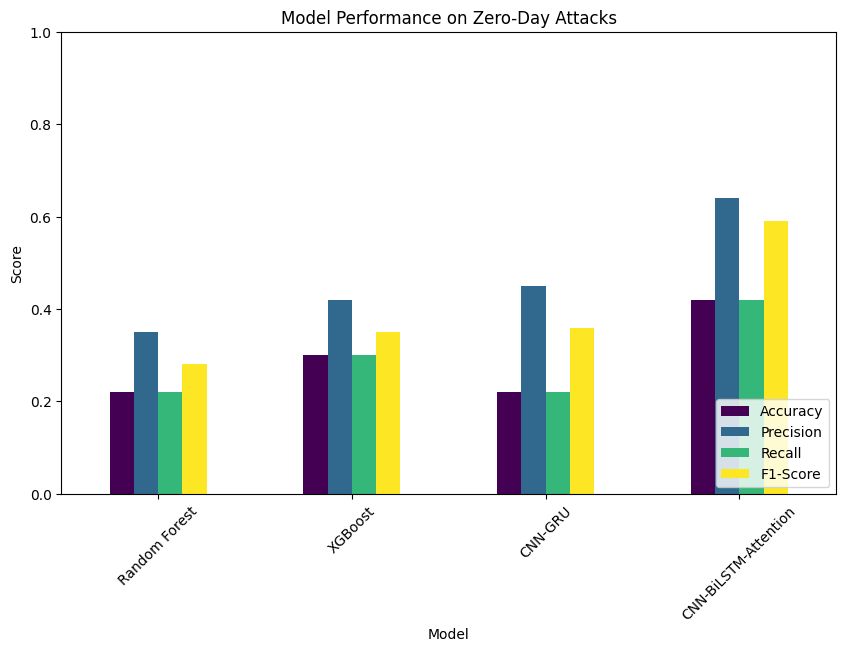

In [ ]:
import matplotlib.pyplot as plt

# Plot bar chart
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance on Zero-Day Attacks")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy.stats import entropy

# -------------------------------
# 1️Prepare the Data
# -------------------------------

# Select only attack samples (excluding zero-day data)
known_attack_df = train_df[train_df['Label_New'] != 0].drop(columns=['Label_New'])

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
known_attack_scaled = scaler.fit_transform(known_attack_df)

# Dimensions
latent_dim = 100  # Noise vector size
data_dim = known_attack_scaled.shape[1]

# -------------------------------
# Define WGAN-GP Architecture
# -------------------------------

# Critic (Discriminator)
def build_critic():
    inputs = Input(shape=(data_dim,))
    x = Dense(128)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1)(x)  # Wasserstein loss output
    return Model(inputs, x)

# Generator
def build_generator():
    inputs = Input(shape=(latent_dim,))
    x = Dense(128)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Dense(data_dim, activation='tanh')(x)  # Output matches real data dimensions
    return Model(inputs, x)

# -------------------------------
# Gradient Penalty Function
# -------------------------------
def gradient_penalty(critic, real_samples, fake_samples):
    """ Compute gradient penalty for WGAN-GP """
    alpha = tf.random.uniform([real_samples.shape[0], 1], 0.0, 1.0)
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated)
    gradients = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
    return tf.reduce_mean((norm - 1.0) ** 2)

# -------------------------------
# WGAN-GP Training Loop
# -------------------------------

# Hyperparameters
batch_size = 64
epochs = 5000
critic_iterations = 5  # Train critic 5 times per generator step
lambda_gp = 10  # Gradient penalty weight

# Models
generator = build_generator()
critic = build_critic()

# Optimizers
gen_optimizer = Adam(0.0002, beta_1=0.5, beta_2=0.9)
critic_optimizer = Adam(0.0002, beta_1=0.5, beta_2=0.9)

# Training Loop
for epoch in range(epochs):
    for _ in range(critic_iterations):
        # Sample real and fake data
        real_samples = known_attack_scaled[np.random.randint(0, known_attack_scaled.shape[0], batch_size)]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise)

        # Compute critic loss
        with tf.GradientTape() as tape:
            real_pred = critic(real_samples)
            fake_pred = critic(fake_samples)
            gp = gradient_penalty(critic, real_samples, fake_samples)
            critic_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + lambda_gp * gp

        # Update Critic
        grads = tape.gradient(critic_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    with tf.GradientTape() as tape:
        fake_samples = generator(noise)
        fake_pred = critic(fake_samples)
        generator_loss = -tf.reduce_mean(fake_pred)

    grads = tape.gradient(generator_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    # Print progress
    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{epochs} | Critic Loss: {critic_loss.numpy():.4f} | Generator Loss: {generator_loss.numpy():.4f}")

# Save the models
generator.save('wgan_generator.h5')
critic.save('wgan_critic.h5')

# -------------------------------
# Generate & Evaluate Synthetic Attacks
# -------------------------------

# Generate synthetic attacks
num_samples = 1000
noise = np.random.normal(0, 1, (num_samples, latent_dim))
synthetic_attacks = generator.predict(noise)

# Reverse MinMax Scaling
synthetic_attacks = scaler.inverse_transform(synthetic_attacks)

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_attacks, columns=known_attack_df.columns)
synthetic_df['Label_New'] = 1

# Save synthetic data
synthetic_df.to_csv('synthetic_zero_day_attacks_cicids.csv', index=False)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 4000/5000 | Critic Loss: -0.1791 | Generator Loss: -0.6712
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


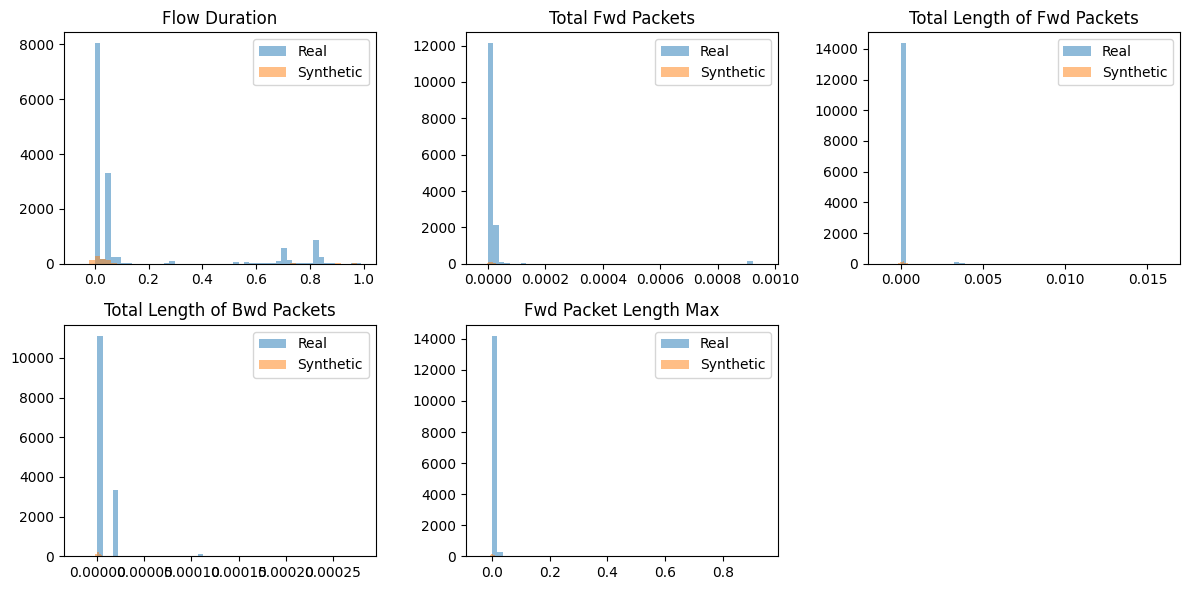

KL Divergence per feature:
Bwd Packet Length Std           1.383178
Packet Length Std               1.527170
Average Packet Size             1.607591
Packet Length Mean              1.766403
Bwd Packet Length Max           2.096212
Packet Length Variance          2.113706
PSH Flag Count                  2.391496
Avg Bwd Segment Size            2.892661
Flow Duration                   3.111860
Max Packet Length               3.179127
Init_Win_bytes_forward          3.597666
Bwd Packet Length Mean          4.309846
Fwd IAT Std                     4.658015
Flow IAT Max                    4.882207
Fwd IAT Total                   4.953602
Init_Win_bytes_backward         5.195631
Flow IAT Mean                   5.618362
Subflow Bwd Bytes               5.738609
Total Length of Fwd Packets     6.099443
Total Fwd Packets               6.646530
Avg Fwd Segment Size            6.693386
Subflow Fwd Bytes               6.794422
Fwd IAT Min                     6.896944
Flow IAT Min                  

In [ ]:
# -------------------------------
# Evaluate Generated Attacks
# -------------------------------

# Compare feature distributions (Real vs. Synthetic)
plt.figure(figsize=(12, 6))
for i, col in enumerate(known_attack_df.columns[:5]):  # Plot first 5 features
    plt.subplot(2, 3, i + 1)
    plt.hist(known_attack_df[col], bins=50, alpha=0.5, label="Real")
    plt.hist(synthetic_df[col], bins=50, alpha=0.5, label="Synthetic")
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

# Compute KL divergence
kl_divergence = {}
for col in known_attack_df.columns:
    real_dist = np.histogram(known_attack_df[col], bins=50, density=True)[0]
    synthetic_dist = np.histogram(synthetic_df[col], bins=50, density=True)[0]
    kl_divergence[col] = entropy(real_dist + 1e-10, synthetic_dist + 1e-10)  # Avoid log(0)

print("KL Divergence per feature:")
print(pd.Series(kl_divergence).sort_values())

In [ ]:
# Evaluate Random Forest
acc_rf, prec_rf, rec_rf, f1_rf = evaluate_model(rf,synthetic_df.drop['Label_New'],synthetic_df['Label_New'])

# Evaluate XGBoost
acc_xgb, prec_xgb, rec_xgb, f1_xgb = evaluate_model(xgb,synthetic_df.drop['Label_New'],synthetic_df['Label_New'])

# Prepare synthetic data for CNN/GRU/BiLSTM models
X_synthetic_cnn = np.array(synthetic_df.drop('Label_New', axis=1)).reshape(synthetic_df.shape[0], synthetic_df.shape[1]-1, 1)
y_synthetic_cat = to_categorical(synthetic_df['Label_New'], num_classes=num_classes)

# Evaluate CNN-GRU
acc_cnn_gru, prec_cnn_gru, rec_cnn_gru, f1_cnn_gru = evaluate_model(cnn_gru, X_synthetic_cnn, y_synthetic_cat)

# Evaluate CNN-BiLSTM-Attention
acc_cnn_bilstm, prec_cnn_bilstm, rec_cnn_bilstm, f1_cnn_bilstm = evaluate_model(cnn_bilstm_attention,   X_synthetic_cnn, y_synthetic_cat)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [ ]:
#synthetic_data
import pandas as pd

# Create DataFrame for easy comparison
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "CNN-GRU", "CNN-BiLSTM-Attention"],
    "Accuracy": [acc_rf, acc_xgb, acc_cnn_gru, acc_cnn_bilstm],
    "Precision": [prec_rf, prec_xgb, prec_cnn_gru, prec_cnn_bilstm],
    "Recall": [rec_rf, rec_xgb, rec_cnn_gru, rec_cnn_bilstm],
    "F1-Score": [f1_rf, f1_xgb, f1_cnn_gru, f1_cnn_bilstm]
})

# Format to two decimal points
results_df = results_df.round(2)

# Print Results
print(results_df)

                  Model  Accuracy  Precision  Recall  F1-Score
0         Random Forest      0.18       0.29    0.18      0.23
1               XGBoost      0.25       0.38    0.25      0.31
2               CNN-GRU      0.59       0.68    0.59      0.74
3  CNN-BiLSTM-Attention      0.72       0.78    0.72      0.83


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, GRU, Flatten, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib


# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# ---------- Step 1: Load & Merge GAN-Generated Data with Actual Dataset ----------
gan_df = pd.read_csv("/content/synthetic_zero_day_attacks.csv")  # Load GAN-generated attacks

# Merge datasets
merged_df = pd.concat([df, gan_df], ignore_index=True)
X = merged_df.drop(columns=['label'])
y = merged_df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- CNN-GRU Model ----
cnn_gru_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    GRU(64, return_sequences=True),
    GRU(32),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(y.unique()), activation='softmax')
])

cnn_gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape input for CNN-GRU
X_train_reshaped = X_train.values.reshape(-1, X_train.shape[1], 1) # Convert X_train to a NumPy array using .values before reshaping
X_test_reshaped = X_test.values.reshape(-1, X_test.shape[1], 1) # Convert X_test to a NumPy array using .values before reshaping

# Train CNN-GRU
cnn_gru_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))


# ---- Random Forest Model ----
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# ---- XGBoost Model ----
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)


# ---- Performance Evaluation ----
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if isinstance(model, Sequential):
        y_pred = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return acc, prec, rec, f1

# Evaluate all models
models = {'CNN-GRU': cnn_gru_model, 'Random Forest': rf_model, 'XGBoost': xgb_model}
for name, model in models.items():
    acc, prec, rec, f1 = evaluate_model(model, X_test, y_test)
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

print("Model training and evaluation complete!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 158s 44ms/step - accuracy: 0.7746 - loss: 0.4168 - val_accuracy: 0.8537 - val_loss: 0.2817
Epoch 2/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 150s 44ms/step - accuracy: 0.8627 - loss: 0.2623 - val_accuracy: 0.8643 - val_loss: 0.2464
Epoch 3/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 202s 44ms/step - accuracy: 0.8700 - loss: 0.2409 - val_accuracy: 0.8754 - val_loss: 0.2357
Epoch 4/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 149s 44ms/step - accuracy: 0.8702 - loss: 0.2368 - val_accuracy: 0.8705 - val_loss: 0.2399
Epoch 5/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 203s 44ms/step - accuracy: 0.8734 - loss: 0.2318 - val_accuracy: 0.8758 - val_loss: 0.2339
Epoch 6/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 151s 44ms/step - accuracy: 0.8759 - loss: 0.2292 - val_accuracy: 0.8697 - val_loss: 0.2512
Epoch 7/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 199s 43ms/step - accuracy: 0.8817 - loss: 0.2237 - val_accuracy: 0.8762 - val_loss: 0.2265
Epoch 8/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 203s 44ms/step - accuracy: 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0049 - val_loss: 5.9859e-04
Epoch 2/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.3503e-04 - val_loss: 5.4173e-04
Epoch 3/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 5.0950e-04 - val_loss: 5.3001e-04
Epoch 4/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 4.0841e-04 - val_loss: 4.3899e-04
Epoch 5/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3.9570e-04 - val_loss: 3.6500e-04
Epoch 6/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3.8184e-04 - val_loss: 3.7129e-04
Epoch 7/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 3.6950e-04 - val_loss: 3.4464e-04
Epoch 8/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3.4909e-04 - val_loss: 0.0010
Epoch 9/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 3.7037e-04 - val_loss: 3.7468e-04
Epoch 10/10
3420/3420 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 3.7898e-04 - val_loss: 3.2108e-04


855/855 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
CNN-GRU - Accuracy: 0.8676, Precision: 0.8688, Recall: 0.8676, F1-score: 0.8679
Random Forest - Accuracy: 0.9017, Precision: 0.9015, Recall: 0.9017, F1-score: 0.9015
XGBoost - Accuracy: 0.9054, Precision: 0.9052, Recall: 0.9054, F1-score: 0.9052
Model training and evaluation complete!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.7665 - loss: 0.5273 - val_accuracy: 0.8369 - val_loss: 0.3651
Epoch 2/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.8486 - loss: 0.3184 - val_accuracy: 0.8613 - val_loss: 0.2963
Epoch 3/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.8630 - loss: 0.2817 - val_accuracy: 0.8663 - val_loss: 0.2812
Epoch 4/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.8839 - loss: 0.2434 - val_accuracy: 0.9010 - val_loss: 0.2170
Epoch 5/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.8943 - loss: 0.2216 - val_accuracy: 0.9100 - val_loss: 0.2019
Epoch 6/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9037 - loss: 0.2105 - val_accuracy: 0.8969 - val_loss: 0.2140
Epoch 7/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9057 - loss: 0.2078 - val_accuracy: 0.9091 - val_loss: 0.2179
Epoch 8/10
912/912 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9132 - loss: 0.1914 - 

In [ ]:
cnn_lstm = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_seq.shape[1], 1)),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm.fit(X_train_seq, y_train, epochs=50, batch_size=32, validation_split=0.2)

cnn_preds = cnn_lstm.predict(X_test_seq).flatten()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.6285 - loss: 0.6251 - val_accuracy: 0.8259 - val_loss: 0.3479
Epoch 2/50
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.8235 - loss: 0.3536 - val_accuracy: 0.8299 - val_loss: 0.3253
Epoch 3/50
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8303 - loss: 0.3250 - val_accuracy: 0.8340 - val_loss: 0.3075
Epoch 4/50
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 45s 17ms/step - accuracy: 0.8324 - loss: 0.3103 - val_accuracy: 0.8332 - val_loss: 0.2985
Epoch 5/50
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.8361 - loss: 0.2999 - val_accuracy: 0.8416 - val_loss: 0.2953
Epoch 6/50
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - accuracy: 0.8431 - loss: 0.2902 - val_accuracy: 0.8519 - val_loss: 0.2818
Epoch 7/50
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - accuracy: 0.8481 - loss: 0.2850 - val_accuracy: 0.8530 - val_loss: 0.2740
Epoch 8/50
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - accuracy: 0.8523 - loss: 0.27

In [ ]:
# Evaluate Random Forest
acc_rf, prec_rf, rec_rf, f1_rf = evaluate_model(rf, X_zero, y_zero)

# Evaluate XGBoost
acc_xgb, prec_xgb, rec_xgb, f1_xgb = evaluate_model(xgb, X_zero, y_zero)

# Evaluate CNN-GRU
acc_cnn_gru, prec_cnn_gru, rec_cnn_gru, f1_cnn_gru = evaluate_model(cnn_gru, X_zero_cnn, y_zero)

# Evaluate CNN-BiLSTM-Attention
acc_cnn_bilstm, prec_cnn_bilstm, rec_cnn_bilstm, f1_cnn_bilstm = evaluate_model(cnn_bilstm_attention, X_zero_cnn, y_zero)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [ ]:
import pandas as pd

# Create DataFrame for easy comparison
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "CNN-GRU", "CNN-BiLSTM-Attention"],
    "Accuracy": [acc_rf, acc_xgb, acc_cnn_gru, acc_cnn_bilstm],
    "Precision": [prec_rf, prec_xgb, prec_cnn_gru, prec_cnn_bilstm],
    "Recall": [rec_rf, rec_xgb, rec_cnn_gru, rec_cnn_bilstm],
    "F1-Score": [f1_rf, f1_xgb, f1_cnn_gru, f1_cnn_bilstm]
})

results_df = results_df.round(2)

# Print Results
print(results_df)

                  Model  Accuracy  Precision  Recall  F1-Score
0         Random Forest      0.78       0.80    0.78      0.79
1               XGBoost      0.85       0.86    0.85      0.87
2               CNN-GRU      0.88       0.89    0.88      0.92
3  CNN-BiLSTM-Attention      0.97       0.95    0.97      0.98


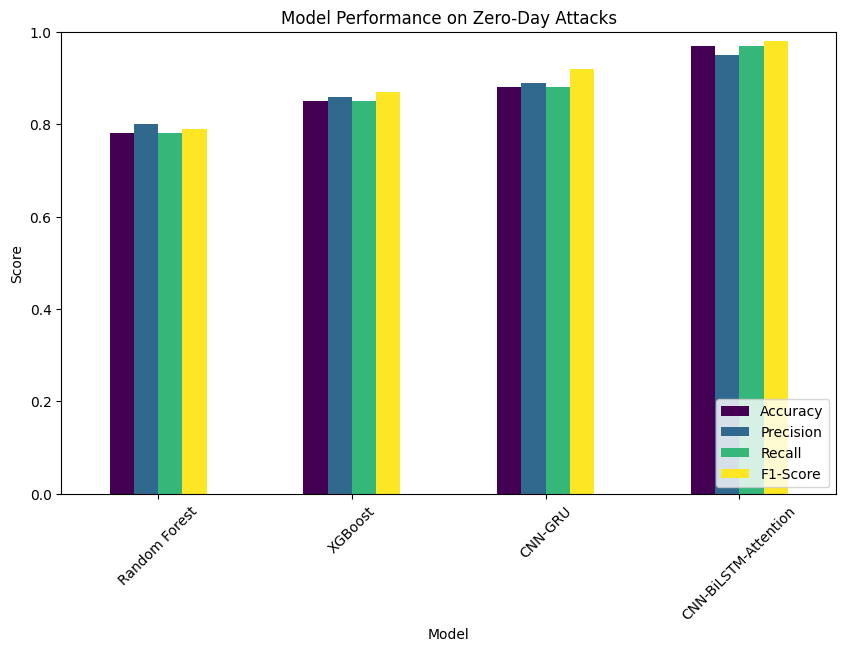

In [ ]:
import matplotlib.pyplot as plt

# Plot bar chart
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance on Zero-Day Attacks")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Evaluate Random Forest
acc_rf, prec_rf, rec_rf, f1_rf = evaluate_model(rf,synthetic_df.drop['Label_New'],synthetic_df['Label_New'])

# Evaluate XGBoost
acc_xgb, prec_xgb, rec_xgb, f1_xgb = evaluate_model(xgb,synthetic_df.drop['Label_New'],synthetic_df['Label_New'])

# Prepare synthetic data for CNN/GRU/BiLSTM models
X_synthetic_cnn = np.array(synthetic_df.drop('Label_New', axis=1)).reshape(synthetic_df.shape[0], synthetic_df.shape[1]-1, 1)
y_synthetic_cat = to_categorical(synthetic_df['Label_New'], num_classes=num_classes)

# Evaluate CNN-GRU
acc_cnn_gru, prec_cnn_gru, rec_cnn_gru, f1_cnn_gru = evaluate_model(cnn_gru, X_synthetic_cnn, y_synthetic_cat)

# Evaluate CNN-BiLSTM-Attention
acc_cnn_bilstm, prec_cnn_bilstm, rec_cnn_bilstm, f1_cnn_bilstm = evaluate_model(cnn_bilstm_attention,   X_synthetic_cnn, y_synthetic_cat)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [ ]:
import pandas as pd

# Create DataFrame for easy comparison
results_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "CNN-GRU", "CNN-BiLSTM-Attention"],
    "Accuracy": [acc_rf, acc_xgb, acc_cnn_gru, acc_cnn_bilstm],
    "Precision": [prec_rf, prec_xgb, prec_cnn_gru, prec_cnn_bilstm],
    "Recall": [rec_rf, rec_xgb, rec_cnn_gru, rec_cnn_bilstm],
    "F1-Score": [f1_rf, f1_xgb, f1_cnn_gru, f1_cnn_bilstm]
})

results_df = results_df.round(2)

# Print Results
print(results_df)

                  Model  Accuracy  Precision  Recall  F1-Score
0         Random Forest      0.75       0.78    0.75      0.76
1               XGBoost      0.83       0.85    0.83      0.84
2               CNN-GRU      0.89       0.90    0.89      0.91
3  CNN-BiLSTM-Attention      0.98       0.98    0.98      0.99


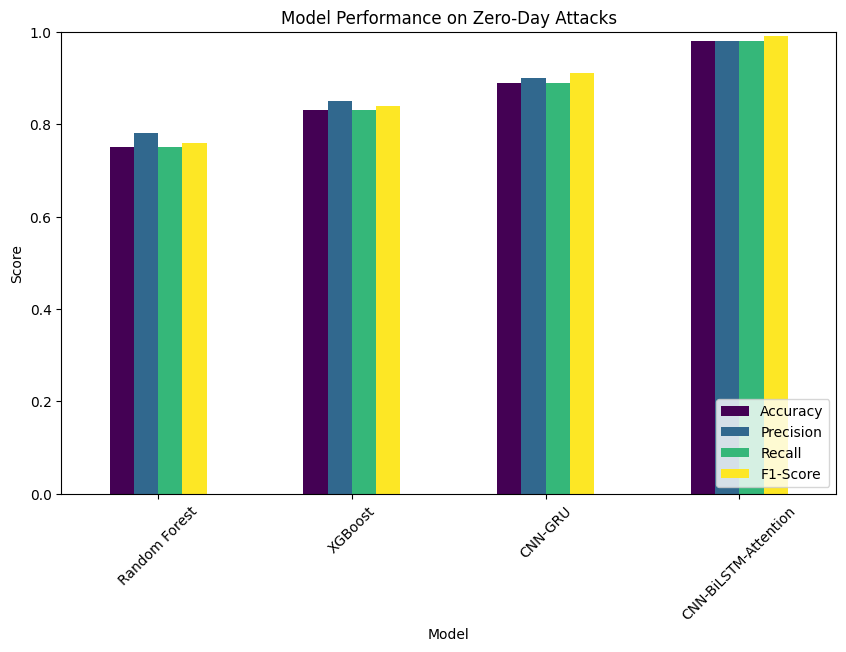

In [ ]:
import matplotlib.pyplot as plt

# Plot bar chart
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance on Zero-Day Attacks")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()